<a href="https://colab.research.google.com/github/sathvikeppakayala/predictive_analytics/blob/main/Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:59:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model Evaluation Metrics:

                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Stacked Model        0.946027   0.896104  0.711340  0.793103  0.899964
Random Forest        0.943028   0.904110  0.680412  0.776471  0.896347
XGBoost              0.941529   0.853659  0.721649  0.782123  0.891608
Gradient Boosting    0.941529   0.871795  0.701031  0.777143  0.887014
Logistic Regression  0.859070   0.536585  0.226804  0.318841  0.817544


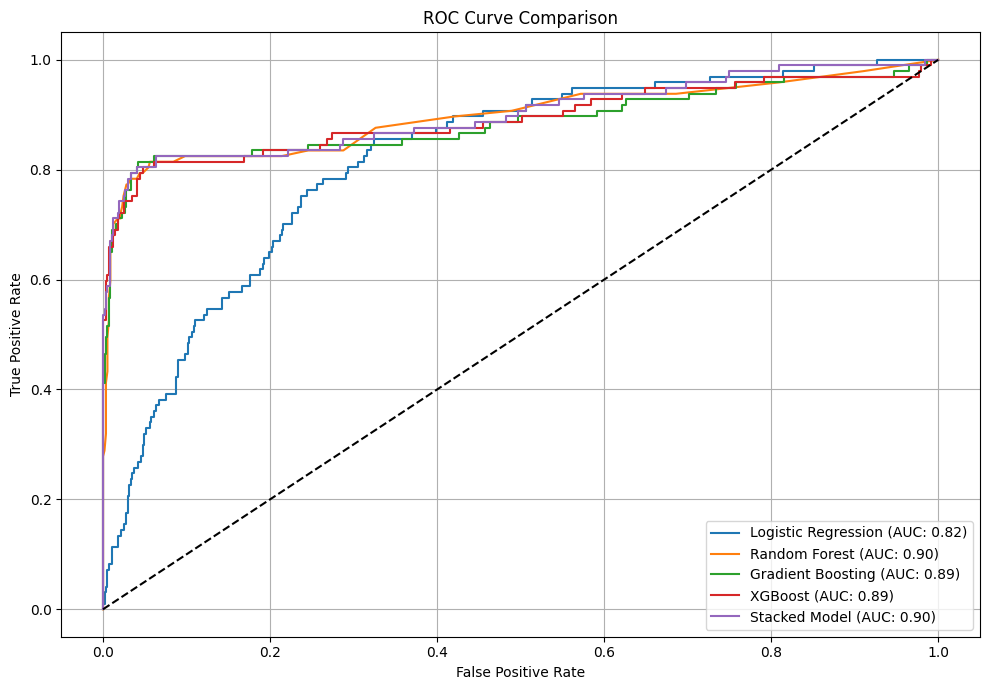

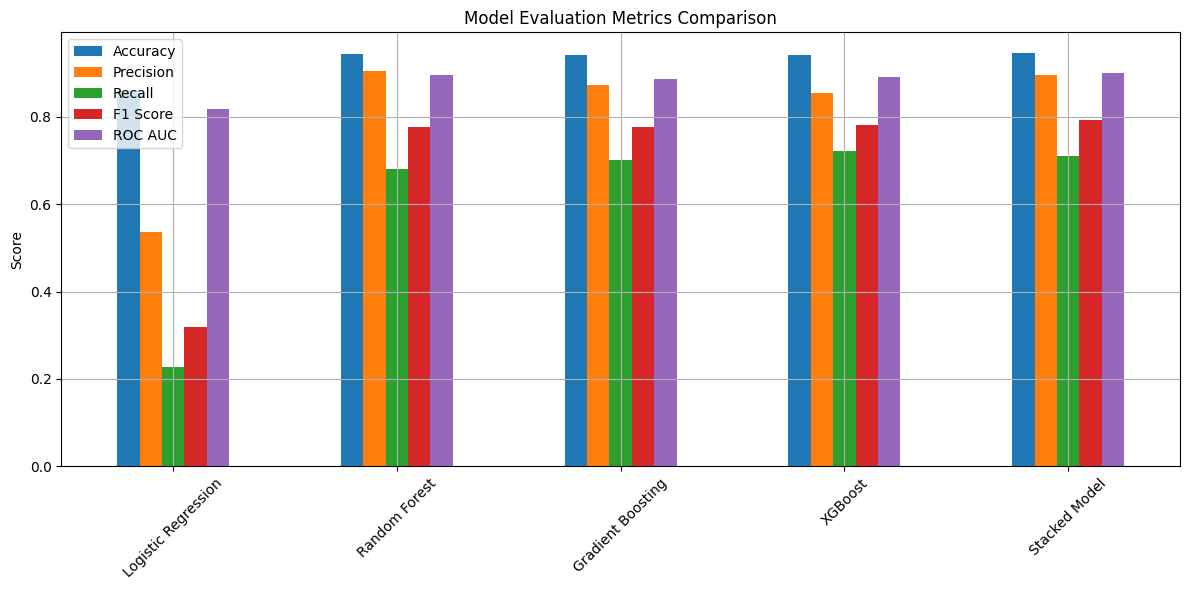

In [2]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Load Data
df = pd.read_csv('churn.csv')
df = df.drop(columns=['Phone'])  # Irrelevant for modeling

# Encode target
df['Churn?'] = df['Churn?'].map({'False.': 0, 'True.': 1})

# Identify columns
categorical_cols = ['State', "Int'l Plan", 'VMail Plan']
numerical_cols = df.drop(columns=categorical_cols + ['Churn?']).columns.tolist()

# Label encode categorical features
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Scale numeric features
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Train-test split
X = df.drop('Churn?', axis=1)
y = df['Churn?']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train and evaluate base models
results = {}
probs_dict = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    probs_dict[name] = probs

    results[name] = {
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds),
        "ROC AUC": roc_auc_score(y_test, probs)
    }

# Meta model (stacking)
stack = StackingClassifier(
    estimators=[
        ('lr', models['Logistic Regression']),
        ('rf', models['Random Forest']),
        ('gb', models['Gradient Boosting']),
        ('xgb', models['XGBoost']),
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=3,
    n_jobs=-1
)

stack.fit(X_train, y_train)
stack_preds = stack.predict(X_test)
stack_probs = stack.predict_proba(X_test)[:, 1]
probs_dict["Stacked Model"] = stack_probs

results["Stacked Model"] = {
    "Accuracy": accuracy_score(y_test, stack_preds),
    "Precision": precision_score(y_test, stack_preds),
    "Recall": recall_score(y_test, stack_preds),
    "F1 Score": f1_score(y_test, stack_preds),
    "ROC AUC": roc_auc_score(y_test, stack_probs)
}

# Display results
results_df = pd.DataFrame(results).T
print("\nModel Evaluation Metrics:\n")
print(results_df.sort_values("ROC AUC", ascending=False))

# Plot ROC Curves
plt.figure(figsize=(10, 7))
for name, probs in probs_dict.items():
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc_score(y_test, probs):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar plot for comparison
results_df[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']].plot(kind='bar', figsize=(12, 6))
plt.title('Model Evaluation Metrics Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
